# Plot NSE CDFs

F2/FX

This notebook was written by Logan Qualls. Data for this work is sourced from the National Center for Atmospheric Research's Catchment Attributes and Meterology for Large-Sample Studies (CAMELS) dataset, and this notebook is designed to work specifically with Frederik Kratzert's NeuralHydrology (NH; https://github.com/neuralhydrology/neuralhydrology) and Grey Nearing's SACSMA-SNOW17 (SAC-SMA; https://github.com/Upstream-Tech/SACSMA-SNOW17). NH provides a flexible framework with a variety of tools specifically designed for straightforward application of Long Short-Term Memory networks to hydrological modeling. The SACSMA-SNOW17 model provides a Python interface for the SAC-SMA model.

So far we have 1) calculted dynamic climate indices, 2) created climate nonstationarity configuration files, 3) created sister job scripts for SAC-SMA, sent off those models, 4) ensembled and analyzed the results, 5) performed more in-depth analyses between two models.

Finally, we can plot metric CDFs for all avaliable experiments.

In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

##### Notebook Configuration

Here we can define which metric we would like to plot in the CDFs. I will use the Nash-Sutcliffe Efficiency (NSE) Coefficient, which is most commonly used to vizualize hydrological model performance, but any metrics calculated in notebook 3/X can be used.

In [3]:
#########################################################################################

#Define climate index to plot CDFs for
index = 'aridity'

#Define if plots are inline or interactive
interactive_plots = False

#########################################################################################

##### Paths

In [4]:
#########################################################################################

#Path to working directory (current directory)
working_dir = Path(os.getcwd())

#Path to notebook_env_saves directory (.../notebook_env_saves)
env_saves_dir = working_dir / 'notebook_env_saves'

#########################################################################################

**You should not have to edit anything below this cell.**

The cell below orients the notebook based on the parameters specifed above.

In [5]:
#########################################################################################

#Get names of avaliable metric functions
metrics = ['nse']
#Set corresponding metric plot lims
axes = [(-1,1,0,1)]
#Create dictionary for metrics and axes
metric_axes_dict = {m:a for (m,a) in zip(metrics, axes)}

#########################################################################################

#Make plots interactive or inline according to value of interactive_plots variable
if interactive_plots:
    %matplotlib notebook
    %matplotlib notebook
else:
    %matplotlib inline
    
#########################################################################################

### Load Source Data

In [6]:
#Retreive list of cdfs files avaliable in env_saves_dir
cdfs_list = [x for x in os.listdir(env_saves_dir) if x.startswith('cdf')]

In [7]:
#Initiate dictionary to store all loaded cdfs files
cdfs = {}

#For every file in cdfs_list...
for cdf in cdfs_list:
    
    #Define path to the file
    path = env_saves_dir / cdf
    
    #Get name from file name
    name = cdf.split('cdfs_')[1].split('.')[0]
    
    #Open path...
    with open(path,'rb') as f:
        
        #...and load
        cdfs[name] = pkl.load(f)

### Plot CDFs

 ##### Daymet and NLDAS Biased vs. Random Train/Test Splits

First we will to create a 2x2 grid of CDF plots for a defined metric for the possible model/forcing pairs. In this case, NeuralHydrology/SAC-SMA and Daymet/NLDAS. Note that I only plot static NeuralHydrology experiments for this figure.

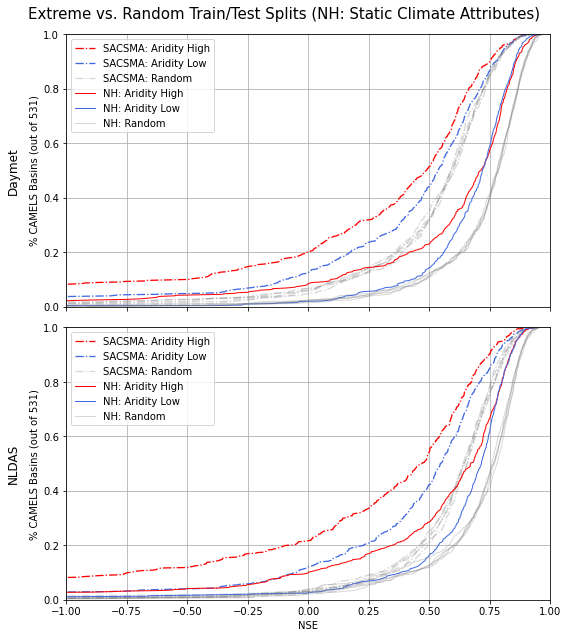

In [8]:
###Format Plot#####################################################

#Define plot rows
rows = ['Daymet','NLDAS']

###Define Variables################################################

#List of models (one for each plot)
models = ['sacsma','nh','sacsma','nh']

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']

#List of subplot positions
ps = [0,0,1,1]

# #List train/test split types
exp_types = ['extreme','random']
year = 'all'
inp = 'static'

#Define spatial pad
pad = 5

###Plot Graph######################################################

#For every metric...
for metric in metrics:
    
    #Create a 2x2 grid of plots (one plot for each model/forcing pair)
    fig, axs = plt.subplots(2,1,figsize = (8,9))
    
    #For every row...
    for ax, row in zip(axs, rows):

        #Create an annotation to signify forcing type
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center',rotation=90)
     
    #Create sub-x and -y labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    
    #For a given position(n,m) where a model/forcing pair is to be plot...
    for i,model,forcing in zip(ps,models,forcings):

        #For every train/test split type...
        for exp_type in exp_types:

            #Create name from scratch to ensure proper calling
            #Naming format changes depending on model type
            if model == 'nh':
                name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
            if model == 'sacsma':
                name = f'{model}_{exp_type}_{forcing}_{year}'
            
            #And if that name matches a key in the cdfs dictionary...
            if name in cdfs.keys():

                #Use that name to access a run's experiments
                experiments = cdfs[name].keys()
                
                #If that experiment is extreme...
                if exp_type == 'extreme':

                    #Retrieve all extreme experiment names
                    experiments = [x for x in experiments if index in x]

                #Set r to 0 (keeps count of how many random cdf lines we plot...
                #...so we don't have 500 "random"s on the legend)
                r = 0

                #For every experiment...
                for experiment in experiments:
                    
                    #Split experiment name by '_'
                    title = experiment.split('_')
                    
                    #Capitalize each element
                    title = [x.capitalize() for x in title]
                    
                    #Rejoin with space
                    title = ' '.join(title)

                    #Retrieve x and y values from cdfs dictionary
                    x = cdfs[name][experiment][metric]['x']
                    y = cdfs[name][experiment][metric]['y']

                    #Default color, transparency, line width, and line type
                    c = 'r'
                    alpha = 1
                    lw = 1
                    l = '-'

                    #If it was a 'low' experiment...
                    if 'low' in experiment:

                        #Decrease the alpha to make it a lighter color
                        c = 'royalblue'

                    #If sacsma model...
                    if 'sacsma' in name:

                        #Make the line dash-dot and line width 1
                        l = '-.'
                        lw = 1.3

                    #If random experiment...
                    if 'random' in name:

                        #Add 1 to r variable
                        r = r + 1
                        #Make line grey
                        c = 'grey'
                        #Decrease alpha
                        alpha = 0.3

                        #If sacsma model...
                        if 'sacsma' in name:

                            #Decrease line width
                            l = '-.'
                            lw = 1.3
                            
                        #If r isn't 1, then set label to None
                        if r != 1:
                            
                            #Plot line without label
                            axs[i].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                            
                            #Then continue
                            continue
                        
                        #If r is 1...
                        else:
                            #Plot line with label
                            axs[i].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: Random')
                            
                            #Then continue
                            continue

                    
                    #Plot x,y with the defined line type/color,width, alpha, and label 
                    axs[i].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: {title}')
                    
        #Show legend
        axs[i].legend()

        #Set axes limits (currently hardcoded for NSE)
        axs[i].set_xlim(left=-1, right=1)
        axs[i].set_ylim(bottom=0, top=1) 
    
    #Show grid in subplots
    axs[0].grid()
    axs[1].grid()

    #Only show axis labels for outter plots
    for ax in axs.flat:
        ax.label_outer()  

    #Create main figure title
    fig.suptitle(f'Extreme vs. Random Train/Test Splits (NH: Static Climate Attributes)', fontsize=15,ha='center')
    
    #Show plot
    plt.tight_layout()

In [9]:
#If plot interactive, must explicitly close
plt.close()

##### "All Years" vs. "Only NWM Years" Date Ranges

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm.

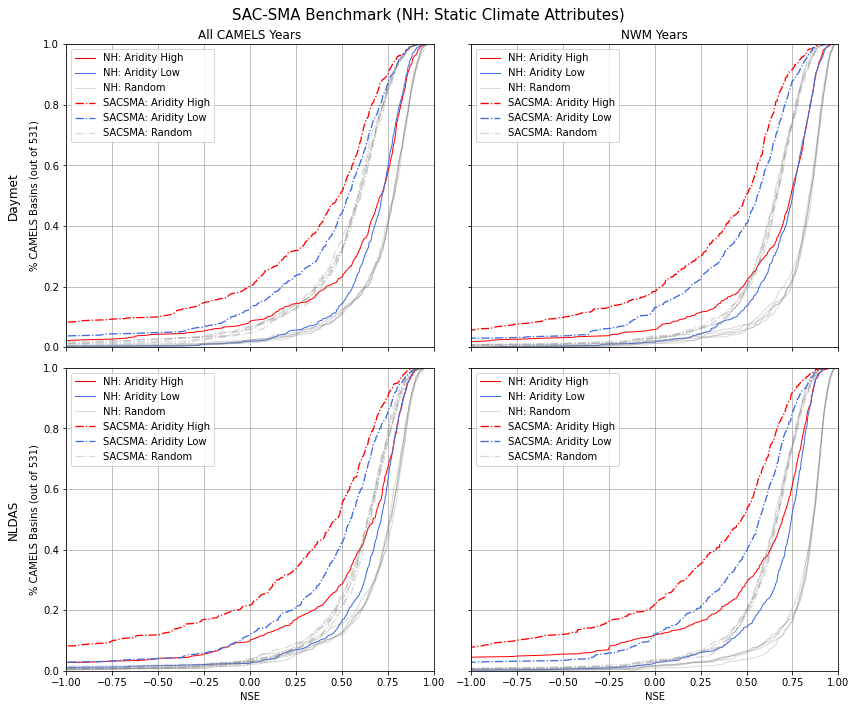

In [10]:
###Format Plot#####################################################

#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
#Row
ns = [0,0,1,1]
#Column
ms = [0,1,0,1]

###Define Variables################################################

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']

#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of models (one for each type)
models = ['nh','sacsma']

#List of experiment types (one for each type)
exp_types = ['extreme','random']

#Type of input (one)
inp = 'static'

###Plot Graph######################################################

#For the metrics we want to plot...
for metric in metrics:

    #Create a 2x2 grid of plots (one plot for each forcing/year pair)
    fig, axs = plt.subplots(2,2,figsize = (12,10))
    
    #Set subplot labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    
    #Define a pad distance between texts
    pad = 5

    #For every column...
    for ax, col in zip(axs[0], cols):

        #Create an annotation to signify years
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #For every row...
    for ax, row in zip(axs[:,0], rows):

        #Create an annotation to signify forcing
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)

    #For a given position (n,m) where a forcing/year pair is to be plot...
    for n,m,forcing,year in zip(ns,ms,forcings,years):
        
        #For each model...
        for model in models:
            
            #And for each experiment type...
            for exp_type in exp_types:
                
                #Create name from scratch to ensure proper calling
                #Naming format changes depending on model type
                if model == 'nh':
                    name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
                if model == 'sacsma':
                    name = f'{model}_{exp_type}_{forcing}_{year}'
                    
                #And if that name matches a key in the cdfs dictionary...
                if name in cdfs.keys():

                    #Use that name to access a run's experiments
                    experiments = cdfs[name].keys()
                    
                    #If plotting extreme models...
                    if exp_type == 'extreme':
                        
                        #Retrieve extreme experiment names based on climate index name
                        experiments = [x for x in experiments if index in x]

                    #Set r to 0 (keeps count of how many random cdf lines we plot...
                    #...so we don't have 500 "random"s on the legend)
                    r = 0

                    #For every experiment...
                    for experiment in experiments:
                        
                        #Split experiment name by '_'
                        title = experiment.split('_')
                        
                        #Capitalize each element
                        title = [x.capitalize() for x in title]
                        
                        #Rejoin with spaces
                        title = ' '.join(title)

                        #Retrieve x and y values from cdfs dictionary
                        x = cdfs[name][experiment][metric]['x']
                        y = cdfs[name][experiment][metric]['y']

                        #Default color, transparency, line width, and line type
                        c = 'r'
                        alpha = 1
                        lw = 1
                        l = '-'

                        #If it was a 'low' experiment...
                        if 'low' in experiment:

                            #Decrease the alpha to make it a lighter color
                            c = 'royalblue'

                        #If sacsma model...
                        if 'sacsma' in name:

                            #Make the line dash-dot and line width 1
                            l = '-.'
                            lw = 1.3

                        #If random experiment...
                        if 'random' in name:

                            #Add 1 to r variable, make line grey, decrease alpha
                            r = r + 1
                            c = 'grey'
                            alpha = 0.3

                            #If sacsma model...
                            if 'sacsma' in name:

                                #Decrease line width
                                l = '-.'
                                lw = 1.3

                            #If r isn't 1, then set label to None
                            if r != 1:
                                
                                #Plot line only
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                                continue
                            
                            #If r is 1...
                            else:

                                #Plot line with label
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: Random')
                                continue
                                
                        #Plot x,y with the defined line type/color,width, alpha, and label 
                        axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: {title}')

        #Show legend
        axs[n,m].legend()

        #Set axes limits
        axs[n,m].set_xlim(left=-1, right=1)
        axs[n,m].set_ylim(bottom=0, top=1)
        
        #Plot grid
        axs[n,m].grid()

    #Only show labels for outside plots
    for ax in axs.flat:
        ax.label_outer()   

    #Create main figure title
    fig.suptitle(f'SAC-SMA Benchmark (NH: Static Climate Attributes)', fontsize=15)

    #Show plot
    plt.tight_layout()

In [11]:
#If plot interactive, must explicitly close
plt.close()

##### Static Attributes vs. Dynamic Climate Index Inputs

Next, we will to create a 2x2 grid of CDF plots for a defined metric for the possible forcing/year pairs. In this case, Daymet/NLDAS and all/nwm. This time, however, instead of plotting SAC-SMA we are only plotting NeuralHydrology. Also, instead of only plotting static experiments, we plot both static and dynamic.

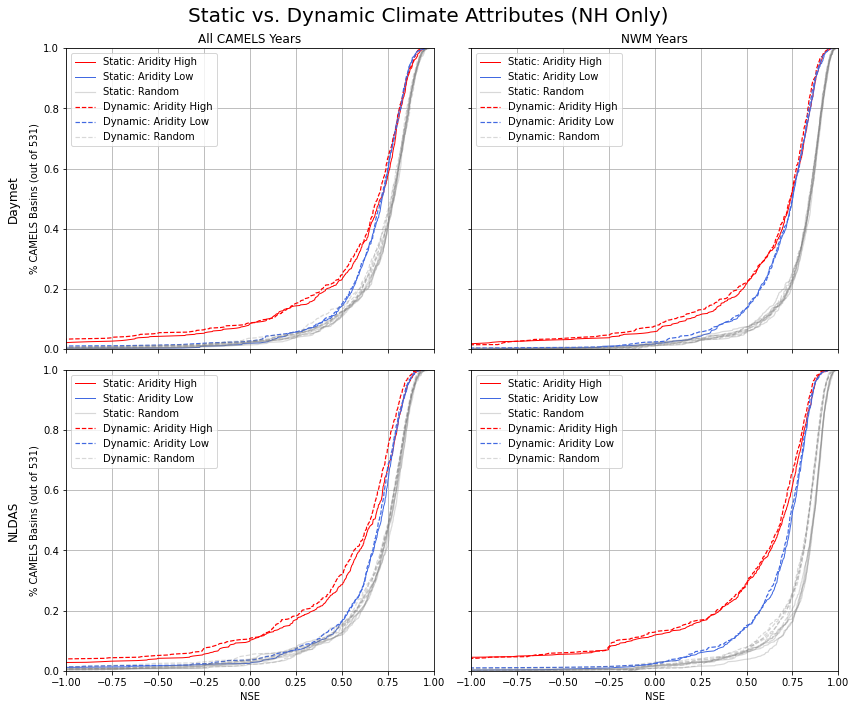

In [12]:
###Format Plot#####################################################

#Define columns and rows of plots
cols = ['All CAMELS Years','NWM Years']
rows = ['Daymet','NLDAS']

#Create list(s) of subplot coordinates
ns = [0,0,1,1]
ms = [0,1,0,1]

###Define Variables################################################

#List of forcings (one for each plot)
forcings = ['daymet','daymet','nldas_extended','nldas_extended']
#List of years (one for each plot)
years = ['all','nwm','all','nwm']

#List of experiment types (one for each type)
exp_types = ['extreme','random']
#List of inputs (one for each type)
inputs = ['static','dynamic']

#Only plot neuralhydrology models (one)
model = 'nh'

###Plot Graph######################################################

#For each metric we want to plot...
for metric in metrics:

    #Create a 2x2 grid of plots (one plot for each forcing/year pair)
    fig, axs = plt.subplots(2,2,figsize = (12,10))

    #Set subplot labels
    plt.setp(axs.flat, xlabel=metric.upper(), ylabel='% CAMELS Basins (out of 531)')
    
    #Define a pad distance between texts
    pad = 5

    #For every column...
    for ax, col in zip(axs[0], cols):

        #Create an annotation to signify years
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')

    #For every row...
    for ax, row in zip(axs[:,0], rows):

        #Create an annotation to signify forcing
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center',rotation=90)

    #For a given position (n,m) where a model/forcing pair is to be plot...
    for n,m,forcing,year in zip(ns,ms,forcings,years):

        #For each input type...
        for inp in inputs:

            #For each experiment type...
            for exp_type in exp_types:

                #Define a name with the current iterators
                name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'

                #And if that name is in the cdfs dictionary...
                if name in cdfs.keys():

                    #Go into that dictionary and retrieve experiment names
                    experiments = cdfs[name].keys()
                    
                    #If plotting extreme experiments...
                    if exp_type == 'extreme':
                        
                        #Get list of extreme experiment names based on climate index
                        experiments = [x for x in experiments if index in x]

                    #Set r to 0 (keeps count of how many random cdf lines we plot...
                    #...so we don't have 500 "random"s on the legend)
                    r = 0

                    #For every experiment...
                    for experiment in experiments:
                        
                        #Split experiment name by '_'
                        title = experiment.split('_')
                        
                        #Capitalize each element
                        title = [x.capitalize() for x in title]
                        
                        #Rejoin with spaces
                        title = ' '.join(title)

                        #Retrieve x and y values from cdfs dictionary
                        x = cdfs[name][experiment]['nse']['x']
                        y = cdfs[name][experiment]['nse']['y']

                        #Default color, transparency, line width, and line type
                        c = 'r'
                        alpha = 1
                        lw = 1
                        l = '-'

                        #If dynamic model...
                        if 'dynamic' in name:

                            #Line type is solid
                            l = '--'
                            lw = 1.2

                        #If 'low' experiment...
                        if 'low' in experiment:

                            #Decrease alpha to make lighter color
                            c = 'royalblue'

                        #If a random experiment...
                        if 'random' in name:

                            #Add count to r variable and make line grey
                            r = r + 1
                            c = 'grey'
                            lw = 1.2
                            alpha = 0.3

                            #If dynamic, make line solid
                            if 'dynamic' in name:
                                lw = 1.2
                                alpha = 0.3

                            #If r isn't 1, then set label to None
                            if r != 1:

                                #Plot line without label
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw)
                                continue

                            #If r is 1...
                            else:

                                #Plot line with label
                                axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{inp.capitalize()}: Random')
                                continue

                        #Plot x,y with the defined line type/color,width, alpha, and label 
                        axs[n,m].plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{inp.capitalize()}: {title}')

        #Show subplot legents
        axs[n,m].legend()

        #Set axes limits
        axs[n,m].set_xlim(left=-1, right=1)
        axs[n,m].set_ylim(bottom=0, top=1)
        
        #Show grid
        axs[n,m].grid()


    #Only show labels for outside plots
    for ax in axs.flat:
        ax.label_outer()   

    #Create main figure title
    fig.suptitle(f'Static vs. Dynamic Climate Attributes (NH Only)', fontsize=20)

    #Show plot
    plt.tight_layout()

In [13]:
#If plot interactive, must explicitly close
plt.close()

##### NWM Benchmark

To create a reasonable NWM model benchmark, we need to use a model trained with the same forcing source (NLDAS) on data extracted from the same date range ("NWM" date range) and only compare scores for basins used for calibration in _both_ the LSTM and NWM model.

Because the 'cdfs' files do not maintain the basin-metric relationship (since they are sorted prior to saving), we need to import the metric files that do detail this relationship. This allow us to exclude basins that were not used in the NWM Benchmark run's calibration.

In [14]:
#Retreive list of cdfs files avaliable in env_saves_dir
metrics_list = [x for x in os.listdir(env_saves_dir) if x.startswith('basin')]

In [15]:
#Initiate dictionary to store all loaded cdfs files
metrics_dict = {}

#For every file in cdfs_list...
for m in metrics_list:
    
    #Define path to the file
    path = env_saves_dir / m

    #Get name from file name
    name = m.split('basin_metrics_')[1].split('.')[0]

    #Open path...
    with open(path,'rb') as f:

        #...and load
        metrics_dict[name] = pkl.load(f)

We can use a list of CAMELS basins that were used in the NWM Benchmark run's calibration (avaliable at https://github.com/jmframe/nwm-post-processing-with-lstm/tree/master/data) to index and plot CDFs that only include the shared 480 basins.

In [16]:
#Define path to nwm basin list
nwm_480 = working_dir / 'config_complementaries' / 'nwm' / 'nwm_480_basins.txt'

#Load in nwm basin list
with open(nwm_480, 'r') as f:
    nwm_480 = f.read()
    
#Parse string
nwm_480 = nwm_480.split('\n')

In [17]:
#Choose example model
metrics_model = list(metrics_dict.keys())[0]

#Choose example experiment from example model
metrics_exp = list(metrics_dict[metrics_model].keys())[0]

#Retrieve list of basins from example experiment from example model (this lists all 531 CAMELS basins)
basins = list(metrics_dict[metrics_model][metrics_exp]['nse'].keys())

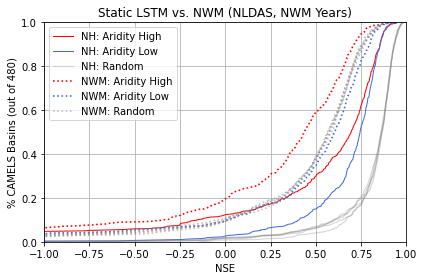

In [18]:
#List of forcings (one for each plot; 1)
forcing = 'nldas_extended'
#List of years (one for each plot; 1)
year = 'nwm'

#List of experiment types (one for each type; 2)
exp_types = ['extreme','random']

#Only plot neuralhydrology and nwm models (one for each type; 2)
models = ['nh','nwm']

#List of inputs (1)
inp = 'static'

###Plot Graph######################################################

#For the defined metrics...
for metric in metrics:

    #For each input type...
    for model in models:

        #For each experiment type...
        for exp_type in exp_types:

            if model == 'nh':
                
                #Define a name with the current iterators
                name = f'{model}_{inp}_{exp_type}_{forcing}_{year}'
                
            if model == 'nwm':
                
                #Define a name with the current iterators (different from nh naming convention)
                name = f'{model}_{exp_type}_{forcing}_{year}'

            #And if that name is in the dictionary...
            if name in metrics_dict.keys():

                #Go into that dictionary and retrieve experiment names
                experiments = metrics_dict[name].keys()
                
                #If plotting extreme experiments...
                if exp_type == 'extreme':
                    
                    #Only use the experiments for the defined climate index
                    experiments = [x for x in experiments if index in x]

                #Set r to 0 (keeps count of how many random cdf lines we plot...
                #...so we don't have 500 "random"s on the legend)
                r = 0

                #For every experiment...
                for experiment in experiments:
                    
                    #Split experiment name by '_'
                    title = experiment.split('_')
                    
                    #Capitalize each element
                    title = [x.capitalize() for x in title]
                    
                    #Rejoin with spaces
                    title = ' '.join(title)

                    #Retrieve x and y values from cdfs dictionary
                    x = np.sort(metrics_dict[name][experiment]['nse'][nwm_480])
                    y = np.arange(len(x))/(float(len(x)))

                    #Default color, transparency, line width, and line type
                    c = 'r'
                    alpha = 1
                    lw = 1
                    l = '-'

                    #If 'low' experiment...
                    if 'low' in experiment:

                        #Decrease alpha to make lighter color
                        c = 'royalblue'
                    
                    #If plotting a nwm experiment...
                    if 'nwm_' in name:
                        
                        l = ':'
                        lw = 1.6

                    #If a random experiment...
                    if 'random' in name:

                        #Add count to r variable and make line grey
                        r = r + 1
                        c = 'grey'
                        lw = 1.2
                        alpha = 0.3
                        
                        #If plotting a nwm experiment...
                        if 'nwm_' in name:

                            l = ':'
                            lw = 1.6
                            alpha = 0.5

                        #If r isn't 1, then set label to None
                        if r != 1:

                            #Plot line without label
                            plt.plot(x,y,l,c=c,alpha=alpha,lw=lw)
                            continue

                        #If r is 1...
                        else:

                            #Plot line with label
                            plt.plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: Random')
                            continue

                    #Plot x,y with the defined line type/color,width, alpha, and label 
                    plt.plot(x,y,l,c=c,alpha=alpha,lw=lw,label=f'{model.upper()}: {title}')

#Show legend
plt.legend()

#Define titles and labels
plt.xlabel('NSE')
plt.ylabel('% CAMELS Basins (out of 480)')
plt.title('Static LSTM vs. NWM (NLDAS, NWM Years)')

#Set axes limits
plt.xlim(left=-1, right=1)
plt.ylim(bottom=0, top=1)

#Show grid
plt.grid() 

#Show plot
plt.tight_layout()